In [1]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

### 生成计算式
## 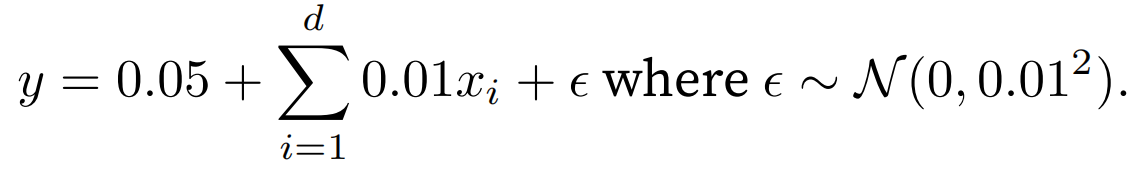

### w为(200,1)向量，表示x1到x200的权重，全是0.01
### 为了使过拟合更明显，用20个样本的小数据集使用200维度复杂模型来拟合
### synthetic_data是创造y=xw+b+noise，传入w，b还有训练数据的个数。
### train_data返回的是总训练数据x(20,200)，y(20,1)
### load_array传入x，y和bs，返回的是dataloader，(bs，单个x)，(bs，单个y)

In [2]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

In [3]:
def init_params():
    w = torch.normal(0, 1, size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

### 定义L2范数惩罚

In [4]:
def l2_penalty(w):
    return torch.sum(w.pow(2)) / 2

### 这里linreg返回xw+b。此时x为(bs,200),w为（200，1）

In [8]:
def train(lambd):
    w, b = init_params()
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    num_epochs, lr = 100, 0.003
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            # 增加了L2范数惩罚项，
            # ⼴播机制使l2_penalty(w)成为⼀个⻓度为batch_size的向量
            l = loss(net(X), y) + lambd * l2_penalty(w)
            l.sum().backward()
            d2l.sgd([w, b], lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                        d2l.evaluate_loss(net, test_iter, loss)))
    # print('w的L2范数是：', torch.norm(w).item())

In [20]:
w = torch.tensor([1,2,3,4])
w.pow(2).sum()

tensor(30)

### 关于lambda

In [17]:
def add(a, b):
    return a+b
add(3,1)

4

In [18]:
add_lambda = lambda a, b: a + b
add_lambda(3,1)

4

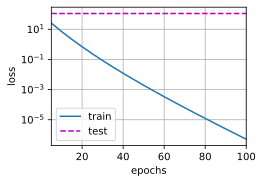

<Figure size 640x480 with 0 Axes>

In [9]:
train(lambd=0)

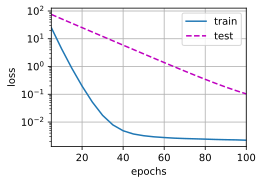

<Figure size 640x480 with 0 Axes>

In [10]:
train(lambd=3)

# 简洁使用

### 将weight_decay写在优化器中，不再加惩罚项进入loss求导了
### 实际中一般取0.001或0.0001

In [14]:
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss(reduction='none')
    num_epochs, lr = 100, 0.003
    # 偏置参数没有衰减
    trainer = torch.optim.SGD([
        {"params":net[0].weight,'weight_decay': wd},
        {"params":net[0].bias}], lr=lr)
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.mean().backward()
            trainer.step()
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1,
                        (d2l.evaluate_loss(net, train_iter, loss),
                        d2l.evaluate_loss(net, test_iter, loss)))

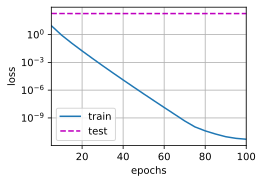

<Figure size 640x480 with 0 Axes>

In [15]:
train_concise(0)

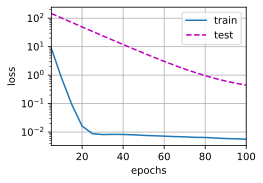

<Figure size 640x480 with 0 Axes>

In [16]:
train_concise(3)